# Light GBM

Light GBM은 Tree 기반의 Gradient Boosting 알고리즘 모델이다. Light GBM은 수평적으로 확장하는 leaf-wise 방식으로 기존 Tree의 level-wise보다 더 많은 loss를 줄일 수 있다. Ligth GBM은 큰 사이즈의 데이터를 적은 메모리 환경에서도 빠르게 처리할 수 있다. 또한 GPU에서의 학습 환경도 지원한다. 하지만, 적은 양의 데이터에서 과적합의 위험도가 높으므로 일정 이상(10,000 Row이상)의 데이터가 필요하다. 

<img src='./image/gbm_diff.png'>

In [3]:
# Light GBM 설치
!pip install lightgbm

You should consider upgrading via the 'C:\ProgramData\Anaconda3\python.exe -m pip install --upgrade pip' command.


In [1]:
import numpy as np
import pandas as pd
from collections import deque
from time import time
from datetime import timedelta
import lightgbm as lgbm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

## 1. Load Datasets

Light GBM을 제대로 활용 하기 위해서는 많은 양의 데이터가 필요하므로 Kaggle에 2020년 심장 질병 예측 데이터를 활용

In [2]:
heart_data = pd.read_csv('./data/heart_2020_cleaned.csv')
heart_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319795 entries, 0 to 319794
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   HeartDisease      319795 non-null  object 
 1   BMI               319795 non-null  float64
 2   Smoking           319795 non-null  object 
 3   AlcoholDrinking   319795 non-null  object 
 4   Stroke            319795 non-null  object 
 5   PhysicalHealth    319795 non-null  float64
 6   MentalHealth      319795 non-null  float64
 7   DiffWalking       319795 non-null  object 
 8   Sex               319795 non-null  object 
 9   AgeCategory       319795 non-null  object 
 10  Race              319795 non-null  object 
 11  Diabetic          319795 non-null  object 
 12  PhysicalActivity  319795 non-null  object 
 13  GenHealth         319795 non-null  object 
 14  SleepTime         319795 non-null  float64
 15  Asthma            319795 non-null  object 
 16  KidneyDisease     31

In [3]:
heart_data.head(3)

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No


## 2. EDA

In [48]:
# 변수의 분포를 보여주는 함수
def show_distribution(df, col):
    """
    :param df: (DataFrame) 데이터
    :param col: (str) 분포를 볼 칼럼명
    :return: None
    """
    # 카디널리티 계산
    cardinality = len(df[col].unique())

    # 카디널리티가 작은 경우 (범주형에 가까운)
    if cardinality < 20:
        fig, axs = plt.subplots(1, 2, figsize=(4 + cardinality, 4))

        # 파이차트, 바차트 그리기
        df_cnt = df[col].value_counts()
        axs[0].pie(df_cnt, labels=df_cnt.index, autopct='%1.1f')
        sns.barplot(x=df_cnt.index, y=df_cnt.values, data=df, ax=axs[1])
        
        # 바 차트에 숫자 표시
        for c in axs[1].containers:
            axs[1].bar_label(c, label_type='center')

        axs[0].set_title(col + ' Pie Chart')
        axs[1].set_title(col + ' Bar Chart')

    # 카디널리티가 큰 경우 (연속형에 가까운)
    else:
        fig, axs = plt.subplots(1, 2, figsize=(8, 4))

        # 박스플롯, 히스토그램 그리기
        sns.boxplot(x=col, data=df, orient='h', ax=axs[0])
        sns.histplot(x=col, data=df, bins=50, ax=axs[1])

        axs[0].set_title(col + ' Box Chart')
        axs[1].set_title(col + ' Hist Chart')
        
    fig.tight_layout()
    plt.show()

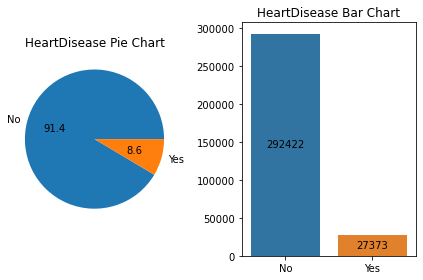

In [49]:
# target 변수의 분포도 확인
col = 'HeartDisease'
show_distribution(heart_data, col)

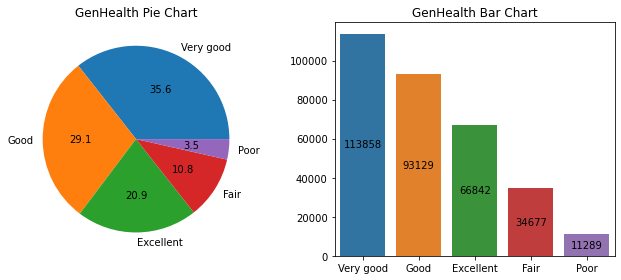

In [44]:
# target 변수의 분포도 확인
col = 'GenHealth'
show_distribution(heart_data, col)

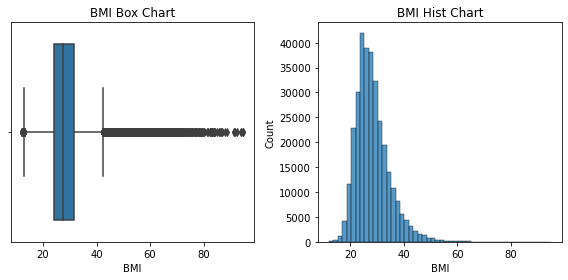

In [45]:
# 변수의 분포도 확인
col = 'BMI'
show_distribution(heart_data, col)

In [127]:
def show_corr_target(df, col, target_col):
    """
    :param df: (DataFrame) 데이터
    :param col: (str) 분포를 볼 칼럼명
    :param target_col: (str) 비교할 타겟 칼럼명
    :return: None
    """
    # 카디널리티 계산
    crd_x = len(df[col].unique())
    crd_y = len(df[target_col].unique())
    crd_threshold = 20

    # x, y 모두 카디널리티가 작은 경우 (범주형에 가까운)
    if crd_x < crd_threshold and crd_y < crd_threshold:
        fig, axs = plt.subplots(1, 2, figsize=(6 + crd_x, 4))

        # 누적 바차트, 퍼센트 히스토그램 그리기
        sns.countplot(x=col, hue=target_col, data=df, ax=axs[0], dodge=False)
        sns.histplot(x=col, hue=target_col, data=df, ax=axs[1],
                     multiple='fill', stat='probability', shrink=0.8)

        # 차트에 숫자 표시
        for c0, c1 in zip(axs[0].containers, axs[1].containers):
            axs[0].bar_label(c0, label_type='center')
            axs[1].bar_label(c1, label_type='center', fmt='%.2f')

        axs[0].set_title('%s: %s Bar Chart' % (col, target_col))
        axs[1].set_title('%s: %s Percent Chart' % (col, target_col))

    # x의 카디널리티가 크고 (연속형에 가까운), y의 카디널리티가 작은 경우 
    elif crd_x > crd_threshold and crd_y < crd_threshold:
        fig, axs = plt.subplots(1, 2, figsize=(8, 4))

        # 박스플롯, 히스토그램 그리기
        sns.boxplot(x=col, data=df, orient='h', ax=axs[0])
        sns.histplot(x=col, data=df, bins=50, ax=axs[1])

        axs[0].set_title(col + ' Hist Chart')

    fig.tight_layout()
    plt.show()

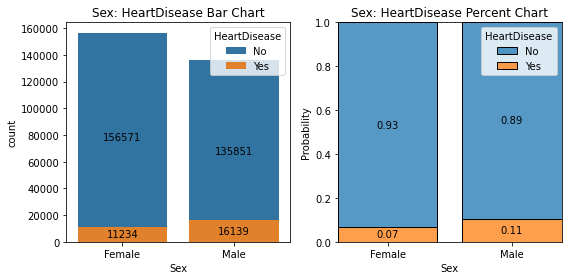

In [128]:
# GenHealth에 따른 HeartDisease의 분포도
col = 'Sex'
target_col = 'HeartDisease'
show_corr_target(heart_data, col, target_col)

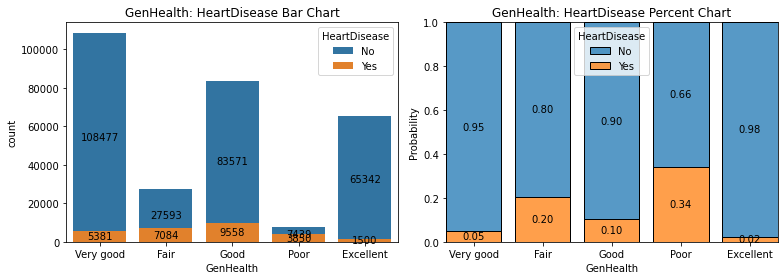

In [124]:
# GenHealth에 따른 HeartDisease의 분포도
col = 'GenHealth'
target_col = 'HeartDisease'
show_corr_target(heart_data, col, target_col)

## 3. PreProcessing

In [132]:
temp = pd.get_dummies(heart_data)
temp[['HeartDisease_Yes', 'HeartDisease_No']]

,HeartDisease_Yes,HeartDisease_No
0,0,1
1,0,1
2,0,1
3,0,1
4,0,1
...,...,...
319790,1,0
319791,0,1
319792,0,1
319793,0,1


## 4. Train